# Finetune a LLM model to follow instructions

A pretrained LLM is very good at text completion, but it is not naturally good at following instructions. The next step is to teach the model to better understand and follow human instructions. This is what many modern platforms do through instruction tuning, enabling the model to respond helpfully, safely, and in a more task-oriented way.

Instruction fine-tuning is often referred to as “**supervised instruction fine-tuning**”, because it involves training a model on a dataset where the input-output pairs are explicitly provided, and, in modern systems, this is often followed by an additional stage such as human reinforcement learning (RLHF) to further improve alignment and behavior.

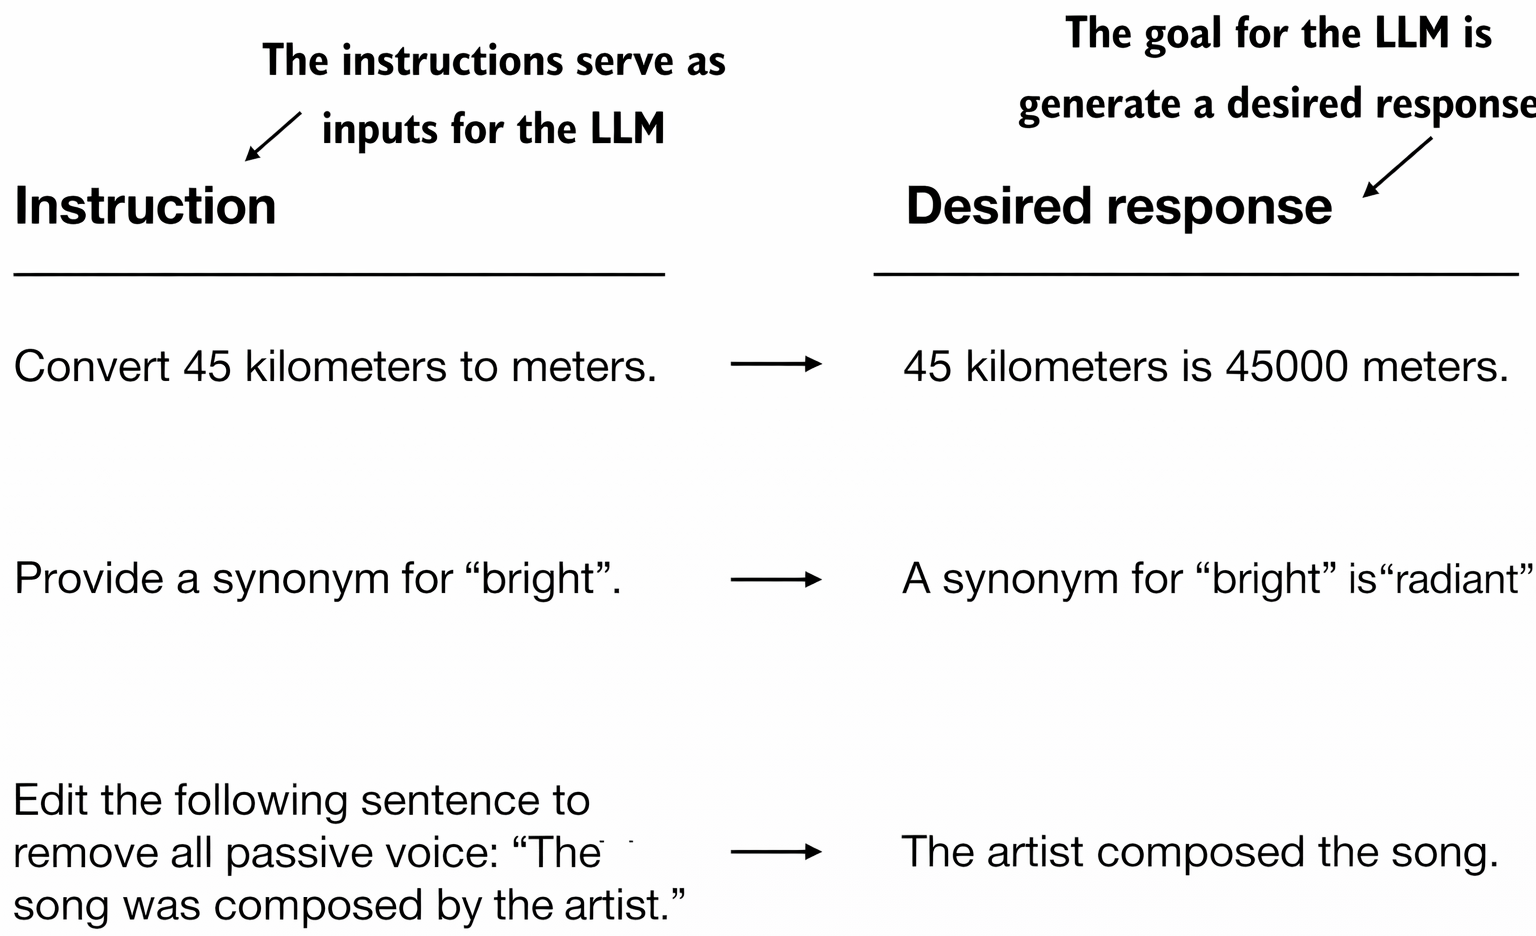

## Prepare a dataset for supervised instruction finetuning

### Get the dataset

The dataset we will use follows the classic instruction-response formatting style, similar to the Alpaca dataset.

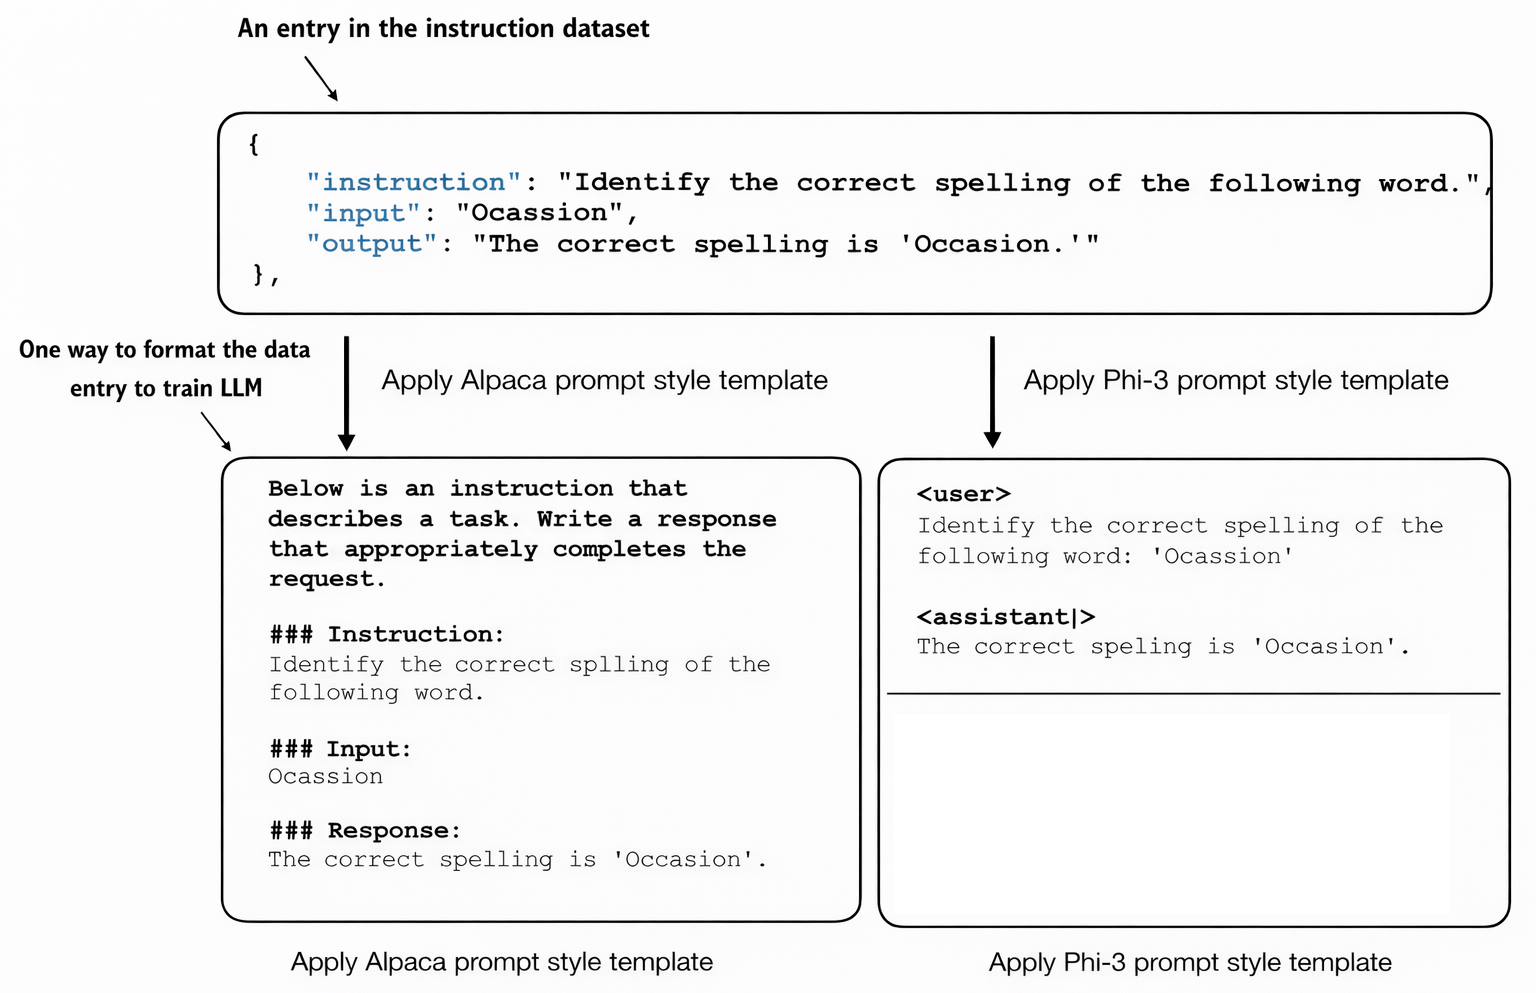

In [1]:
file_path = "/content/instruction-data.json"

In [2]:
import json

with open(file_path, "r", encoding="utf-8") as file:
  data = json.load(file)

In [3]:
print(data)
print("Number of entries:", len(data))

[{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.', 'input': 'freind --> friend', 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}, {'instruction': 'Edit the following sentence for grammar.', 'input': 'He go to the park every day.', 'output': 'He goes to the park every day.'}, {'instruction': 'Convert 45 kilometers to meters.', 'input': '', 'output': '45 kilometers is 45000 meters.'}, {'instruction': "Rewrite this sentence to start with 'Although': Despite the rain, they went for a walk.", 'input': '', 'output': 'Although it was raining, they went for a walk.'}, {'instruction': 'What are the first 10 square numbers?', 'input': '', 'output': '1, 4, 9, 16, 25, 36, 49, 64, 81, 100.'}, {'instruction': 'Suggest a more formal synonym for "happy."', 'input': '', 'output': 'A more formal synonym for "happy" is "content."'}, {'instruction': 'Translate the following sentence into French.', 'input': 'W

In [4]:
# inspect a sample
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [5]:
# another sample (notice that the input field here is empty)
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


### Preprocess the dataset

Helper function to get the dataset's samples in a more structured and useful way.

In [6]:
def format_input(entry):
  instruction_text = (
      f"Below is an instruction that describes a task. "
      f"Write a response that appropriately completes the request."
      f"\n\n### Instruction:\n{entry['instruction']}"
    )

  input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

  return instruction_text + input_text

In [7]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [8]:
# without an input field
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response) # response will bbe used only during training

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


Split to train, val and test sets.

In [9]:
train_portion = int(len(data) * 0.85) # 85% for training
test_portion = int(len(data) * 0.1) # 10% for testing
val_portion = len(data) - train_portion - test_portion # remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [10]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


Organize data.

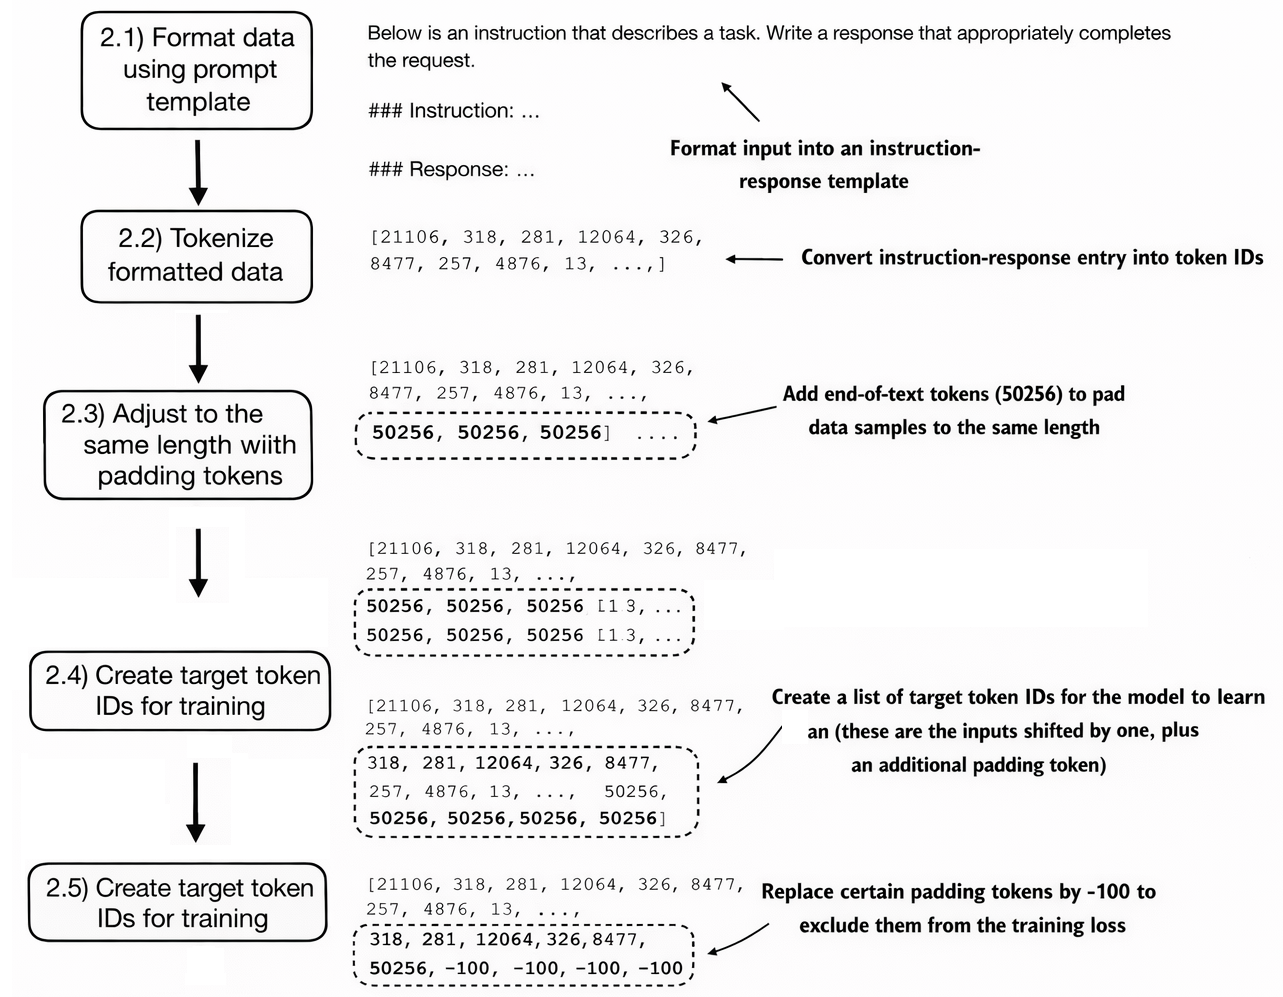

In [11]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):

  def __init__(self, data, tokenizer):

    self.data = data
    self.encoded_texts = []

    for entry in data:
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      full_text = instruction_plus_input + response_text
      self.encoded_texts.append(tokenizer.encode(full_text))

  def __getitem__(self, index):
    return self.encoded_texts[index]

  def __len__(self):
    return len(self.data)

In [12]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In the padding process, we fill the sequence with the `<|endoftext|>` token (ID `50256`). From all these padding tokens, we keep only the first one to explicitly mark the end of the text, while all the remaining ones will be set to `-100` later, so they are ignored by the loss function during training.

In [13]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
  # find the longest sequence in the batch and increase the max length by +1, which will add one extra padding token below
  batch_max_length = max(len(item)+1 for item in batch)

  # pad and prepare inputs
  inputs_lst = []

  for item in batch:
    new_item = item.copy()
    # add an <|endoftext|> token
    new_item += [pad_token_id]
    # pad sequences to batch_max_length
    padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
    # via padded[:-1], we remove the extra padded token that has been added via the +1 setting in batch_max_length
    # (the extra padding token will be relevant in later codes)
    inputs = torch.tensor(padded[:-1])
    inputs_lst.append(inputs)

  # convert list of inputs to tensor and transfer to target device
  inputs_tensor = torch.stack(inputs_lst).to(device)

  return inputs_tensor

In [14]:
# test with a dummy example
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (inputs_1, inputs_2, inputs_3)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


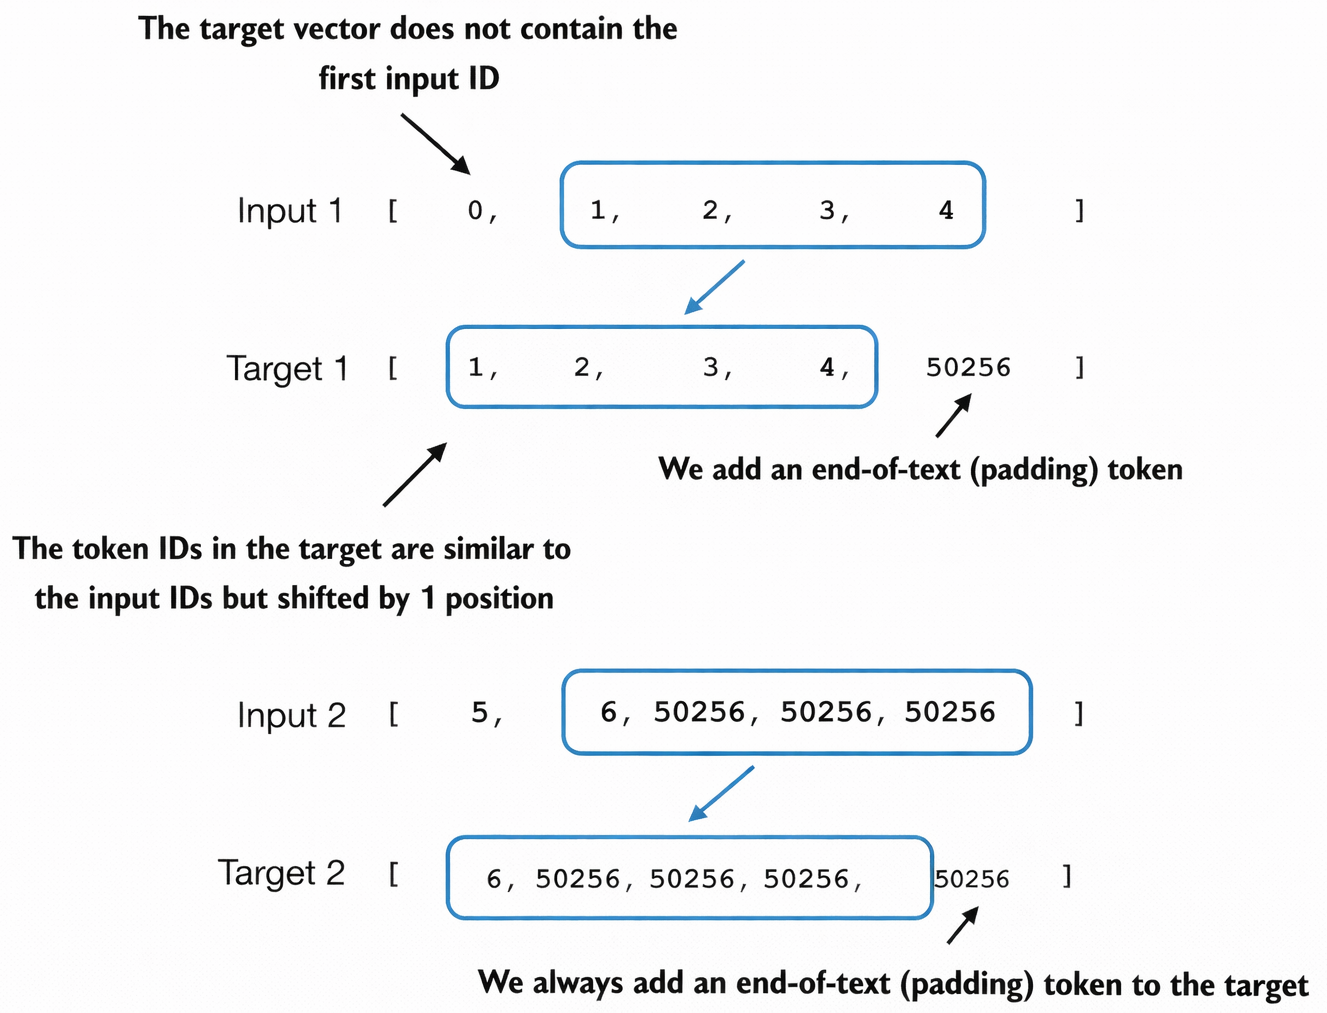

In [15]:
# update the function to also include the corresponding targets (inputs shifted by one)
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
  # find the longest sequence in the batch
  batch_max_length = max(len(item)+1 for item in batch)

  # pad and prepare inputs
  inputs_lst, targets_lst = [], []

  for item in batch:
    new_item = item.copy()
    # add an <|endoftext|> token
    new_item += [pad_token_id]
    # pad sequences to max_length
    padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
    inputs = torch.tensor(padded[:-1]) # truncate the last token for inputs
    targets = torch.tensor(padded[1:]) # shift +1 to the right for targets
    inputs_lst.append(inputs)
    targets_lst.append(targets)

  # convert list of inputs to tensor and transfer to target device
  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)

  return inputs_tensor, targets_tensor

In [16]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


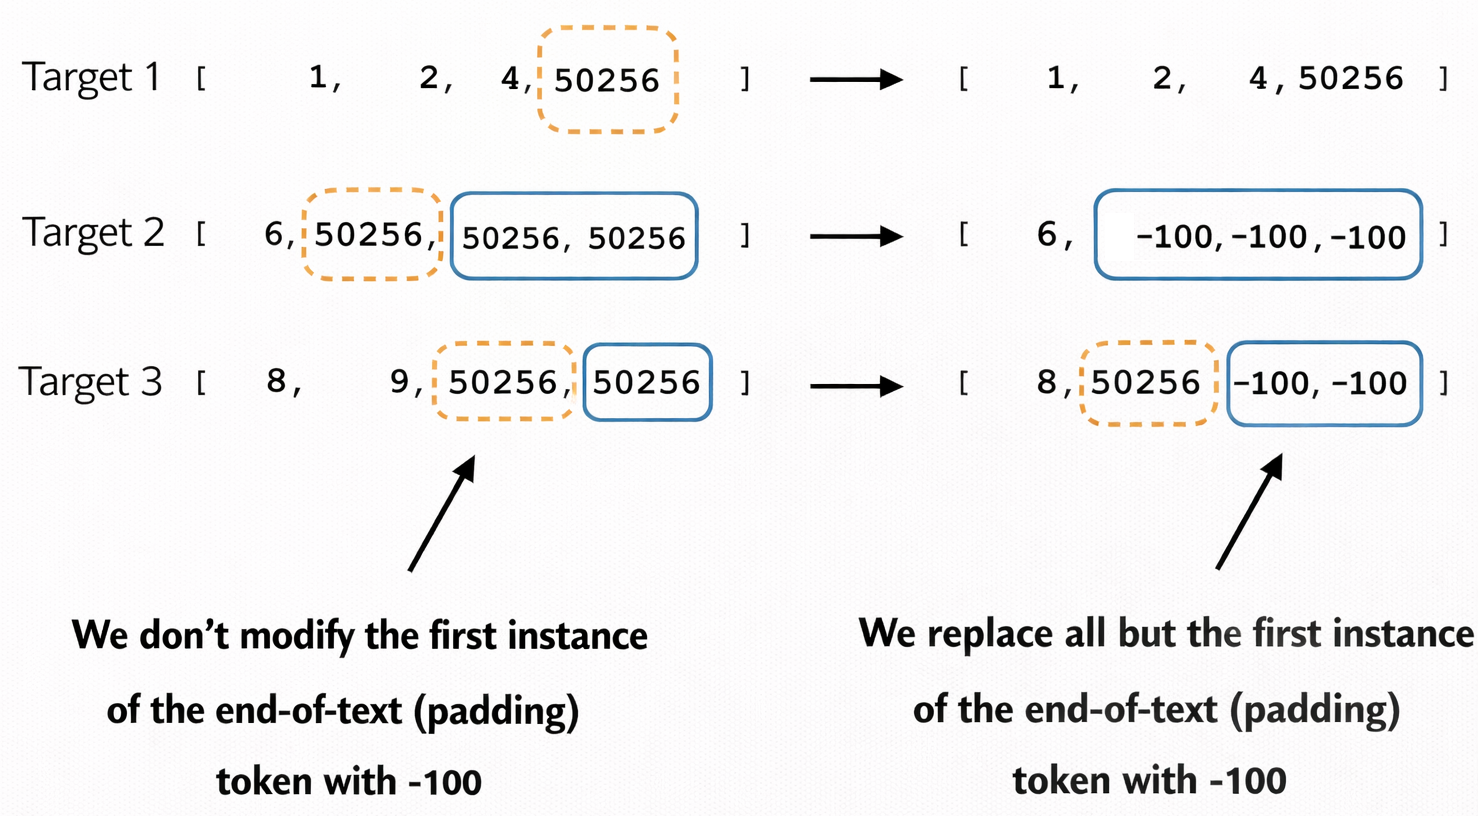

In [17]:
# last update: keep the first padding token and ignore all the rest
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
  # find the longest sequence in the batch
  batch_max_length = max(len(item)+1 for item in batch)

  # pad and prepare inputs and targets
  inputs_lst, targets_lst = [], []

  for item in batch:
    new_item = item.copy()
    # add an <|endoftext|> token
    new_item += [pad_token_id]
    # pad sequences to max_length
    padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
    inputs = torch.tensor(padded[:-1]) # truncate the last token for inputs
    targets = torch.tensor(padded[1:]) # shift +1 to the right for targets

    # replace all but the first padding tokens in targets by ignore_index
    mask = targets == pad_token_id
    indices = torch.nonzero(mask).squeeze()
    if indices.numel() > 1:
      targets[indices[1:]] = ignore_index

    # optionally truncate to maximum sequence length
    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length]
      targets = targets[:allowed_max_length]

    inputs_lst.append(inputs)
    targets_lst.append(targets)

  # convert list of inputs and targets to tensors and transfer to target device
  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)

  return inputs_tensor, targets_tensor

In [18]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


Compute the loss using a simple dummy sample to better understand why we use `-100` and how it excludes padding tokens from the training loss.

In [19]:
logits_1 = torch.tensor(
    [[-1.0, 1.0], # 1st training example
     [-0.5, 1.5]] # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [20]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]] # a new 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [21]:
# add -100: it tells to the loss to ignore the 3rd training example
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


Create datasets and dataloaders.

In [22]:
if torch.cuda.is_available():
  device = torch.device("cuda")
elif torch.backends.mps.is_available():
  major, minor = map(int, torch.__version__.split(".")[:2])
  if (major, minor) >= (2, 9):
    device = torch.device("mps")
  else:
    device = torch.device("cpu")
else:
  device = torch.device("cpu")

print("Device:", device)

Device: cuda


In [23]:
# use functools.partial to pre-fill arguments so we don't repeat them later (this creates a new collate function that always uses the given device and max length)
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [24]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=customized_collate_fn, shuffle=True, drop_last=True, num_workers=num_workers)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=customized_collate_fn, shuffle=False, drop_last=False, num_workers=num_workers)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=customized_collate_fn, shuffle=False, drop_last=False, num_workers=num_workers)

In [25]:
print("Train loader:")
for inputs, targets in train_loader:
  print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

All batches have a batch size of 8 but a different length, as expected. Let's inspect one of them.

In [26]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


In [27]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


## Load a pretrained LLM

In [28]:
from gpt_download import download_and_load_gpt2
from utils import GPTModel, load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257, # vocabulary size
    "context_length": 1024, # context length
    "drop_rate": 0.0, # dropout rate
    "qkv_bias": True # query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)" # choice of a larger model here

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 130kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 622kiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 175kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [05:57<00:00, 3.97MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 14.9MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 632kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 327kiB/s]


In [29]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

Let's see how the model performs on one of the validation tasks, before start finetuning.

In [30]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [31]:
from utils import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)

In [32]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [33]:
# remove the input from the output
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## Finetune the LLM on instruction data

In [34]:
from utils import calc_loss_loader, train_model_simple

In [35]:
# calculate the initial training and validation set loss before we start training
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
  val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.825909376144409
Validation loss: 3.7619347095489504


In [36]:
# train (finetune) the model
import time

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

start_time = time.time()
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 2.637, Val loss 2.626
Epoch 1 (Step 000005): Train loss 1.174, Val loss 1.103
Epoch 1 (Step 000010): Train loss 0.872, Val loss 0.944
Epoch 1 (Step 000015): Train loss 0.857, Val loss 0.906
Epoch 1 (Step 000020): Train loss 0.776, Val loss 0.881
Epoch 1 (Step 000025): Train loss 0.754, Val loss 0.859
Epoch 1 (Step 000030): Train loss 0.799, Val loss 0.836
Epoch 1 (Step 000035): Train loss 0.714, Val loss 0.808
Epoch 1 (Step 000040): Train loss 0.672, Val loss 0.806
Epoch 1 (Step 000045): Train loss 0.633, Val loss 0.789
Epoch 1 (Step 000050): Train loss 0.663, Val loss 0.783
Epoch 1 (Step 000055): Train loss 0.760, Val loss 0.763
Epoch 1 (Step 000060): Train loss 0.719, Val loss 0.743
Epoch 1 (Step 000065): Train loss 0.653, Val loss 0.735
Epoch 1 (Step 000070): Train loss 0.533, Val loss 0.729
Epoch 1 (Step 000075): Train loss 0.568, Val loss 0.729
Epoch 1 (Step 000080): Train loss 0.604, Val loss 0.725
Epoch 1 (Step 000085): Train loss 0.509, Val los

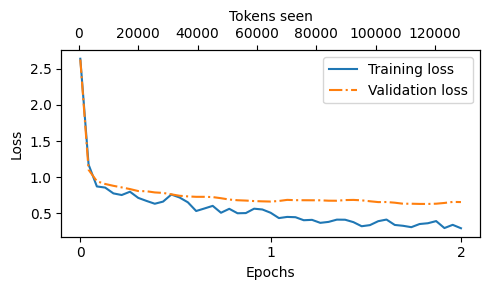

In [44]:
# let's take a look at the training and validation loss curves
from utils import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Extract and save model's respones on test data

In [45]:
torch.manual_seed(123)

for entry in test_data[:3]:

  input_text = format_input(entry)

  token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
  )
  generated_text = token_ids_to_text(token_ids, tokenizer)
  response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
  )

  print(input_text)
  print(f"\nCorrect response:\n>> {entry['output']}")
  print(f"\nModel response:\n>> {response_text.strip()}")
  print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

In [46]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

  input_text = format_input(entry)

  token_ids = generate(
      model=model,
      idx=text_to_token_ids(input_text, tokenizer).to(device),
      max_new_tokens=256,
      context_size=BASE_CONFIG["context_length"],
      eos_id=50256
      )
  generated_text = token_ids_to_text(token_ids, tokenizer)
  response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

  test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
  json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [01:11<00:00,  1.54it/s]


In [47]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [48]:
# also save the model
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


## Evaluate the finetuned LLM

We automate the response evaluation of the finetuned LLM using another, larger LLM (LLM as a judge).

In [52]:
from openai import OpenAI

api_key = None
with open("OPENAI_API_KEY.env") as f:
  for line in f:
    if line.startswith("OPENAI_API_KEY"):
      api_key = line.strip().split("=",1)[1]

client = OpenAI(api_key=api_key)

In [53]:
# test an openai model
def run_chatgpt(prompt, client, model="gpt-4o-mini"):
  response = client.chat.completions.create(
      model=model,
      messages=[{"role": "user", "content": prompt}],
      temperature=0.0,
      seed=123,
  )
  return response.choices[0].message.content


prompt = "Respond with 'hello world' if you got this message."
run_chatgpt(prompt, client)

'hello world'

In [59]:
# we evaluate on our test data
print(len(test_data))

110


In [60]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [64]:
for entry in test_data[:5]:
  prompt = (f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['model_response']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            )
  print("\nTarget response:")
  print(">>", entry['output'])
  print("\nModel response:")
  print(">>", entry["model_response"])
  print("\nScore (based on another LLM):")
  print(">>", run_chatgpt(prompt, client))
  print("\n-------------------------")


Target response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score (based on another LLM):
>> I would score the model response "The car is as fast as a bullet." a 95. 

This response effectively uses a simile to convey the speed of the car, similar to the provided correct output. It captures the essence of the original sentence while maintaining clarity and vivid imagery. The only reason it doesn't receive a perfect score is that "as fast as lightning" is a more commonly used simile, which might resonate more with readers. However, "as fast as a bullet" is still a strong and valid simile.

-------------------------

Target response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.

Score (based on another LLM):
>> The model response states that the type of cloud associated with thunderstorms is a cumulus cloud, which is incor

In [66]:
# the responses are very verbose, we only keep the scores
def generate_model_scores(test_data, key, client):
  scores = []
  for entry in tqdm(test_data, desc="Scoring entries"):
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry[key]}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
        f"Respond with the number only."
    )
    score = run_chatgpt(prompt, client)
    try:
      scores.append(int(score))
    except ValueError:
      continue

  return scores

In [69]:
for model in ("model_response",): # tuple here in case of adding a second model response (RLHF)
  scores = generate_model_scores(test_data, model, client)
  print(f"\n{model}")
  print(f"Number of scores: {len(scores)} of {len(test_data)}")
  print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [02:12<00:00,  1.21s/it]


model_response
Number of scores: 110 of 110
Average score: 41.41

